In [1]:
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]
!pip install stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=cf5f01ac6cb0276ca22ee6b7225e6b86f213ddf30600f7937a67e4abbe8937a3
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvi

In [2]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time
import uuid

from stable_baselines3.common.atari_wrappers import ClipRewardEnv, FireResetEnv, MaxAndSkipEnv, NoopResetEnv

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [3]:
ENV_ARGS = {
    'id': "BreakoutNoFrameskip-v4"
}
NUM_ENVS = 3
SEED = 1
LR = 3e-4
NUM_STEPS = 2048
NUM_ITERATIONS = 4000
GAMMA = 0.99
GAE_LAMBDA = 0.95
UPDATE_EPOCHS = 10
CLIP_COEF = 0.2 # the epsilon in KL divergece in PPO paper
ENTROPY_COEF = 0.0
VF_COEF = 0.5
MAX_GRAD_NORM = 0.5
MINI_BATCH_COUNT = 64
UPDATE_PLOTS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', DEVICE)

#output directory
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output')

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

#seeding
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device =  cuda


In [4]:
gym.envs.registration.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV26Environment-v0', 'GymV21Environment-v0', 'Adventure-v0', 'AdventureDeterministic-v0', 'AdventureNoFrameskip-v0

In [5]:
env = gym.make(**ENV_ARGS)

In [6]:
def make_env(**env_args):
    env = gym.make(**env_args)
    # env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip = 4)
    env = ClipRewardEnv(env)
    env = gym.wrappers.ResizeObservation(env, (84,84))
    env = gym.wrappers.GrayScaleObservation(env)
    env = gym.wrappers.FrameStack(env, 4)
    return env


In [7]:
# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
)

assert isinstance(envs.single_action_space, gym.spaces.Discrete), 'Only discrete action is supported'

In [8]:
def layer_init(layer: nn.Linear, std = np.sqrt(2), bias_const = 0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Agent(nn.Module):

    def __init__(self, envs: gym.Env, hidden_size: int = 512):

        super().__init__()

        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride = 4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride = 2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride = 1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, hidden_size)),
            nn.ReLU(),
        )

        self.actor = layer_init(nn.Linear(hidden_size, envs.single_action_space.n), std = 0.01)
        self.critic = layer_init(nn.Linear(hidden_size,1 ), std = 1.0)

    def get_value(self, x):
        return self.critic(self.network(x/255.0))

    def get_action_and_value(self, x, action = None):
        '''
        @params:
            x: torch.tensor observation, shape = (N, observation size)
            action: torch.tensor action
        @returns:
            action: torch.tensor, shape = (N, action size)
            log_prob: torch.tensor, shape = (N,)
            entropy: torch.tensor, shape = (N,)
            value: torch.tensor, shape = (N,)
        '''

        hidden = self.network(x/255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action == None:
            action = probs.sample()

        log_prob = probs.log_prob(action)
        entropy = probs.entropy()
        value = self.critic(hidden)
        return action, log_prob, entropy, value


In [9]:
#Test agent
# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
)

assert isinstance(envs.single_action_space, gym.spaces.Discrete), 'Only discrete action is supported'

obs, info = envs.reset()
obs = torch.tensor(obs).float()
print('obs shape = ', obs.shape)

test_agent = Agent(envs)

action, log_prob, entropy, value = test_agent.get_action_and_value(obs)

print('action shape = ', action.shape)
print('log prob shape = ', log_prob.shape)
print('entropy shape = ', entropy.shape)
print('value shape = ', value.shape)

envs.close()
del test_agent


obs shape =  torch.Size([3, 4, 84, 84])
action shape =  torch.Size([3])
log prob shape =  torch.Size([3])
entropy shape =  torch.Size([3])
value shape =  torch.Size([3, 1])


In [10]:
def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()

    plt.clf()
    plt.close()

In [11]:
def evaluate(agent, episodes = 10):
    envs = gym.vector.SyncVectorEnv([lambda: make_env(**ENV_ARGS)])
    agent.eval()
    total_rewards = []
    next_obs, _ = envs.reset()

    while len(total_rewards) < episodes:
        next_obs = torch.Tensor(next_obs)
        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)

        next_obs, reward, terminated, truncated, info = envs.step(action.numpy())

        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r'][0]
                    total_rewards.append(reward)

    return total_rewards

In [ ]:
# Create env
envs = gym.vector.AsyncVectorEnv(
    [lambda: make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
)

agent = Agent(envs).to(DEVICE)
optimizer = torch.optim.AdamW(agent.parameters(), lr=LR, eps=1e-5, amsgrad=True)

M = NUM_STEPS
N = NUM_ENVS

label = str(uuid.uuid4()).split('-')[0]
print('run id = ', label)

SAVE_PATH = os.path.join(OUTPUT, label)
FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

obs = torch.zeros((M, N) + envs.single_observation_space.shape, device=DEVICE)
actions = torch.zeros((M, N) + envs.single_action_space.shape, device=DEVICE)
log_probs = torch.zeros((M, N), device=DEVICE)
rewards = torch.zeros((M, N), device=DEVICE)
dones = torch.zeros((M, N), device=DEVICE)  # for masking
values = torch.zeros((M, N), device=DEVICE)

global_step = 0

next_obs, _ = envs.reset()
next_obs = torch.tensor(next_obs, device=DEVICE)
next_done = torch.zeros(N, device=DEVICE)  # N is num envs

print('next obs = ', next_obs.shape)
print('next done = ', next_done.shape)

reward_window = deque(maxlen=100)
history = defaultdict(list)

loop = tqdm(range(NUM_ITERATIONS))
agent.train()

best_score = float('-inf')
evaluation = 0
loss = float('inf')

for iter in loop:
    if iter % UPDATE_PLOTS == 0:
        plot(history, save_path=FIG_SAVE_PATH)

    for step in range(M):
        global_step += N

        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()

        actions[step] = action
        log_probs[step] = log_prob

        next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
        next_done = torch.logical_or(torch.tensor(terminated), torch.tensor(truncated)).to(DEVICE)

        rewards[step] = torch.tensor(reward, device=DEVICE).view(-1)
        next_obs = torch.tensor(next_obs, device=DEVICE)

        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r']
                    reward_window.append(reward)
                    avg_reward = torch.tensor(list(reward_window)).mean().item()
                    history['reward'].append(avg_reward)
                    loop.set_description(f"Reward = {avg_reward:.2f}, Global Step = {global_step}, Best Score = {best_score:.2f}, Loss = {loss:.2f}, Steps = {step}")

                    if best_score < avg_reward:
                        best_score = avg_reward
                        torch.save(agent.state_dict(), os.path.join(SAVE_PATH, 'ppo.checkpoint.torch'))

# Continue with optimization phase
        # OPTIMIZE phase:
    with torch.no_grad():
        # Bootstrap values, compute returns
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards, device=DEVICE)
        last_gae_lam = 0

        for t in reversed(range(M)):
            if t == M - 1:
                next_non_terminal = 1.0 - next_done.float()
                next_values = next_value
            else:
                next_non_terminal = 1.0 - dones[t + 1].float()
                next_values = values[t + 1]

            # GAE-Lambda advantage calculation
            delta = rewards[t] + GAMMA * next_values * next_non_terminal - values[t]
            advantages[t] = last_gae_lam = delta + GAMMA * GAE_LAMBDA * next_non_terminal * last_gae_lam

            # Compute returns by adding values to advantages
        returns = advantages + values

    # Flatten the tensors to prepare for mini-batch gradient descent
    b_obs = obs.view((-1,) + envs.single_observation_space.shape)
    b_actions = actions.view((-1,) + envs.single_action_space.shape)
    b_log_probs = log_probs.view(-1)
    b_advantages = advantages.view(-1)
    b_returns = returns.view(-1)
    b_values = values.view(-1)

    # Batch indices preparation for mini-batch updates
    batch_size = M * N
    mini_batch_size = batch_size // MINI_BATCH_COUNT
    b_indices = torch.arange(batch_size, device=DEVICE)
    clip_fracs = []

    for epoch in range(UPDATE_EPOCHS):
        # Shuffle batch indices to decorrelate the batches
        b_indices = b_indices[torch.randperm(batch_size)]

        for start in range(0, batch_size, mini_batch_size):
            end = start + mini_batch_size
            mini_indices = b_indices[start:end]

            _, new_log_prob, entropy, new_value = agent.get_action_and_value(b_obs[mini_indices], b_actions[mini_indices])

            # Policy gradient loss calculation
            log_ratio = new_log_prob - b_log_probs[mini_indices]
            ratio = torch.exp(log_ratio)

            # Calculate surrogate losses - there is with torch.no_grad() missing here to approximate KL
            surr1 = ratio * b_advantages[mini_indices]
            surr2 = torch.clamp(ratio, 1.0 - CLIP_COEF, 1.0 + CLIP_COEF) * b_advantages[mini_indices]
            policy_loss = -torch.min(surr1, surr2).mean()

            # Value loss using mean squared error
            value_loss = 0.5 * (new_value.view(-1) - b_returns[mini_indices]).pow(2).mean()

            # Total loss
            loss = policy_loss + VF_COEF * value_loss - ENTROPY_COEF * entropy.mean()

            # Perform gradient descent step
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), MAX_GRAD_NORM)
            optimizer.step()

            # Optional: collect information about clipping
            clip_frac = ((ratio - 1.0).abs() > CLIP_COEF).float().mean().item()
            clip_fracs.append(clip_frac)

# Final evaluation and model saving after training
#evaluation = evaluate(agent)  # Assuming evaluate function returns a scalar or a tensor
#print('Final evaluation score:', evaluation)
torch.save(agent.state_dict(), os.path.join(SAVE_PATH, 'ppo.checkpoint.torch'))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


run id =  c1839c50
next obs =  torch.Size([3, 4, 84, 84])
next done =  torch.Size([3])


Reward = 46.08, Global Step = 714510, Best Score = 90.75, Loss = -0.46, Steps = 601:   3%|▎         | 116/4000 [22:06<12:12:12, 11.31s/it]

In [ ]:
import torch

def evaluate(agent, episodes=10):
    # Create a synchronous vector environment
    envs = gym.vector.SyncVectorEnv([lambda: make_env(**ENV_ARGS) for _ in range(NUM_ENVS)])

    # Put the agent into evaluation mode
    agent.eval()

    total_rewards = []
    episode_rewards = [0.0] * NUM_ENVS  # Initialize rewards for each environment
    episode_counts = [0] * NUM_ENVS    # Track the number of episodes completed per environment

    # Reset environments
    obs, _ = envs.reset()
    obs = torch.tensor(obs, dtype=torch.float32).to(DEVICE)  # Convert observations to tensors

    while min(episode_counts) < episodes:
        with torch.no_grad():
            action, _, _, _ = agent.get_action_and_value(obs)
            action = action.cpu().numpy()  # Convert actions to numpy array for the environment

        next_obs, rewards, terminated, truncated, infos = envs.step(action)

        # Update episode rewards and counts
        for i in range(NUM_ENVS):
            episode_rewards[i] += rewards[i]
            if terminated[i] or truncated[i]:
                total_rewards.append(episode_rewards[i])
                print(f"Environment {i+1}, Episode {episode_counts[i]+1}/{episodes}: Reward = {episode_rewards[i]:.2f}")
                episode_rewards[i] = 0  # Reset the reward counter for the next episode
                episode_counts[i] += 1  # Increment the episode count for this environment

        # Prepare next observations
        obs = torch.tensor(next_obs, dtype=torch.float32).to(DEVICE)

        # If enough episodes have been completed, break early
        if min(episode_counts) >= episodes:
            break

    envs.close()  # Always make sure to close environments
    return total_rewards

# Example usage:
#test_agent = Agent(NUM_ENVS, envs.single_action_space.n).to(DEVICE)  # Make sure the agent is properly initialized
test_agent = agent
average_reward = np.mean(evaluate(test_agent, episodes=10))
print("Evaluation Average Reward:", average_reward)


Environment 2, Episode 1/10: Reward = 10.00
Environment 3, Episode 1/10: Reward = 50.00
Environment 2, Episode 2/10: Reward = 31.00
Environment 2, Episode 3/10: Reward = 50.00
Environment 3, Episode 2/10: Reward = 81.00
Environment 3, Episode 3/10: Reward = 16.00
Environment 2, Episode 4/10: Reward = 88.00
Environment 3, Episode 4/10: Reward = 39.00
Environment 2, Episode 5/10: Reward = 24.00
Environment 3, Episode 5/10: Reward = 40.00
Environment 2, Episode 6/10: Reward = 45.00
Environment 2, Episode 7/10: Reward = 10.00
Environment 3, Episode 6/10: Reward = 45.00
Environment 2, Episode 8/10: Reward = 19.00
Environment 2, Episode 9/10: Reward = 19.00
Environment 3, Episode 7/10: Reward = 64.00
Environment 2, Episode 10/10: Reward = 41.00
Environment 3, Episode 8/10: Reward = 35.00
Environment 2, Episode 11/10: Reward = 97.00
Environment 3, Episode 9/10: Reward = 78.00
Environment 3, Episode 10/10: Reward = 15.00
Environment 3, Episode 11/10: Reward = 19.00
Environment 2, Episode 12/10

KeyboardInterrupt: 

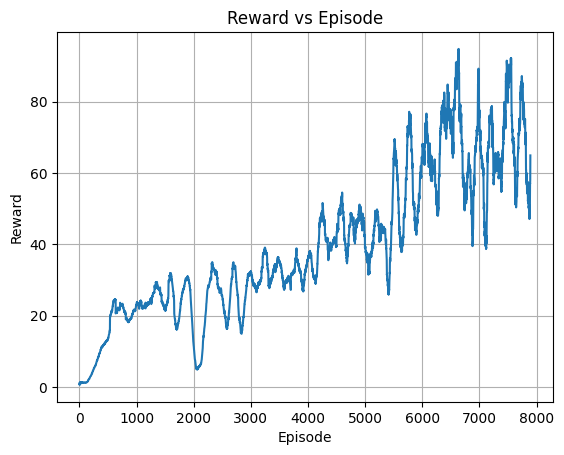

In [ ]:
import matplotlib.pyplot as plt

# Load the training history from the saved file
# Assuming 'history' is a dictionary containing the reward history
# history = ...

# Plot reward versus episode
plt.plot(history['reward'])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward vs Episode')
plt.grid(True)
plt.show()


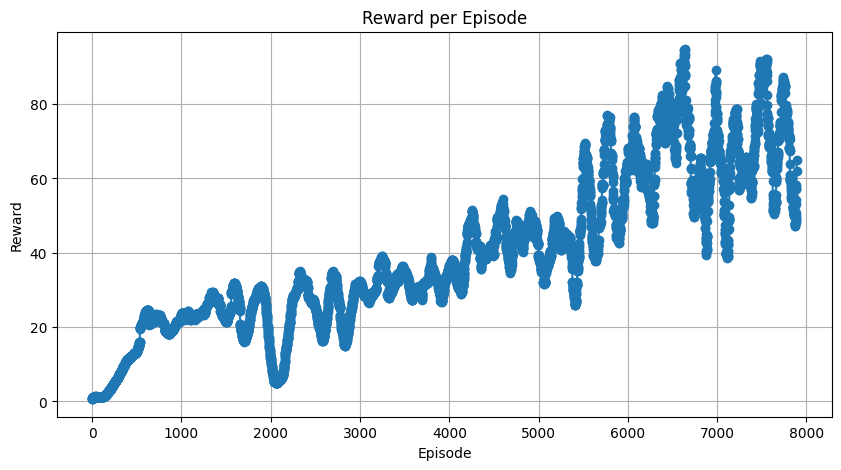

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history['reward'], marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)

# Show the plot
plt.show()